In [1]:
import argparse
import os
import pprint
import shutil
import sys

import logging
import time
import timeit
from pathlib import Path

import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
from tensorboardX import SummaryWriter

import _init_paths
import models
import datasets
from config import config
from config import update_config
from core.criterion import CrossEntropy, OhemCrossEntropy
from core.function import train, validate
from utils.modelsummary import get_model_summary
from utils.utils import create_logger, FullModel

In [2]:
def parse_args():
    parser = argparse.ArgumentParser(description='Train segmentation network')
    
    parser.add_argument('--cfg',
                        help='experiment configure file name',
                        required=True,
                        type=str)
    parser.add_argument('--seed', type=int, default=304)
    parser.add_argument("--local_rank", type=int, default=-1)       
    parser.add_argument('opts',
                        help="Modify config options using the command-line",
                        default=None,
                        nargs=argparse.REMAINDER)

    args = parser.parse_args()
    update_config(config, args)

    return args

def get_sampler(dataset):
    from utils.distributed import is_distributed
    if is_distributed():
        from torch.utils.data.distributed import DistributedSampler
        return DistributedSampler(dataset)
    else:
        return None

In [3]:
seed = 304
import random
print('Seeding with', seed)
random.seed(seed)
torch.manual_seed(seed)

# cudnn related setting
cudnn.benchmark = True
cudnn.deterministic = False
cudnn.enabled = True
gpus = list((0, ))
local_rank = -1
distributed = local_rank >= 0
if distributed:
    device = torch.device('cuda:{}'.format(local_rank))    
    torch.cuda.set_device(device)
    torch.distributed.init_process_group(
        backend="nccl", init_method="env://",
    )

Seeding with 304


In [4]:
BATCH_SIZE_PER_GPU = 8
print(len(gpus))
if distributed:
    batch_size = BATCH_SIZE_PER_GPU
else:
    batch_size = BATCH_SIZE_PER_GPU * len(gpus)
print("batch_size: ", batch_size)

1
batch_size:  8


In [5]:
# prepare data
IMAGE_SIZE = [512, 512]
DATASET = 'spacenet7'
ROOT = '/local_storage/datasets/sn7_winner_split/train/'
TRAIN_SET = 'list/train.lst'
NUM_CLASSES = 2
MULTI_SCALE = True
FLIP = True
IGNORE_LABEL = -1
BASE_SIZE = 512
DOWNSAMPLERATE = 1
SCALE_FACTOR = 16
SHUFFLE = True
WORKERS = 1

crop_size = (IMAGE_SIZE[1], IMAGE_SIZE[0])
train_dataset = eval('datasets.'+ DATASET)(
                    root=ROOT,
                    list_path=TRAIN_SET,
                    num_samples=None,
                    num_classes=NUM_CLASSES,
                    multi_scale=MULTI_SCALE,
                    flip=FLIP,
                    ignore_label=IGNORE_LABEL,
                    base_size=BASE_SIZE,
                    crop_size=crop_size,
                    downsample_rate=DOWNSAMPLERATE,
                    scale_factor=SCALE_FACTOR)

train_sampler = get_sampler(train_dataset)
trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=SHUFFLE and train_sampler is None,
    num_workers=WORKERS,
    pin_memory=True,
    drop_last=True,
    sampler=train_sampler)

In [6]:
epoch = 0
current_trainloader = trainloader
if current_trainloader.sampler is not None and hasattr(current_trainloader.sampler, 'set_epoch'):
    current_trainloader.sampler.set_epoch(epoch)

In [7]:
for i_iter, batch in enumerate(trainloader, 0):
    """
    TCR: two branches, CE1 + CE2 + TCR
    Add cloud information
    """
    images, labels, clouds, size, name, images1, labels1, clouds1, size1, name1 = batch
    break

In [8]:
if images.size() == images1.size():
    print(images.size())

torch.Size([8, 3, 512, 512])


In [9]:
if labels.size() == labels1.size():
    print(labels.size())

torch.Size([8, 512, 512])


In [10]:
if clouds.size() == clouds1.size():
    print(clouds.size())

torch.Size([8, 512, 512])


In [11]:
print(size)
print(size1)

tensor([[512, 512,   3],
        [512, 512,   3],
        [512, 512,   3],
        [512, 512,   3],
        [512, 512,   3],
        [512, 512,   3],
        [512, 512,   3],
        [512, 512,   3]])
tensor([[512, 512,   3],
        [512, 512,   3],
        [512, 512,   3],
        [512, 512,   3],
        [512, 512,   3],
        [512, 512,   3],
        [512, 512,   3],
        [512, 512,   3]])


In [12]:
print(name)

['global_monthly_2018_05_mosaic_L15-0544E-1228N_2176_3279_13_Buildings_02560_02048', 'global_monthly_2018_04_mosaic_L15-1025E-1366N_4102_2726_13_Buildings_00512_00000', 'global_monthly_2019_08_mosaic_L15-0331E-1257N_1327_3160_13_Buildings_00512_01024', 'global_monthly_2018_05_mosaic_L15-0358E-1220N_1433_3310_13_Buildings_01536_02560', 'global_monthly_2018_05_mosaic_L15-0331E-1257N_1327_3160_13_Buildings_01536_01024', 'global_monthly_2019_03_mosaic_L15-1210E-1025N_4840_4088_13_Buildings_00000_02048', 'global_monthly_2018_06_mosaic_L15-1672E-1207N_6691_3363_13_Buildings_01024_02560', 'global_monthly_2019_03_mosaic_L15-1204E-1202N_4816_3380_13_Buildings_02560_02048']


In [13]:
print(name1)

['global_monthly_2019_05_mosaic_L15-0544E-1228N_2176_3279_13_Buildings_02560_02048', 'global_monthly_2018_09_mosaic_L15-1025E-1366N_4102_2726_13_Buildings_00512_00000', 'global_monthly_2018_11_mosaic_L15-0331E-1257N_1327_3160_13_Buildings_00512_01024', 'global_monthly_2019_05_mosaic_L15-0358E-1220N_1433_3310_13_Buildings_01536_02560', 'global_monthly_2019_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings_01536_01024', 'global_monthly_2019_01_mosaic_L15-1210E-1025N_4840_4088_13_Buildings_00000_02048', 'global_monthly_2019_06_mosaic_L15-1672E-1207N_6691_3363_13_Buildings_01024_02560', 'global_monthly_2018_09_mosaic_L15-1204E-1202N_4816_3380_13_Buildings_02560_02048']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


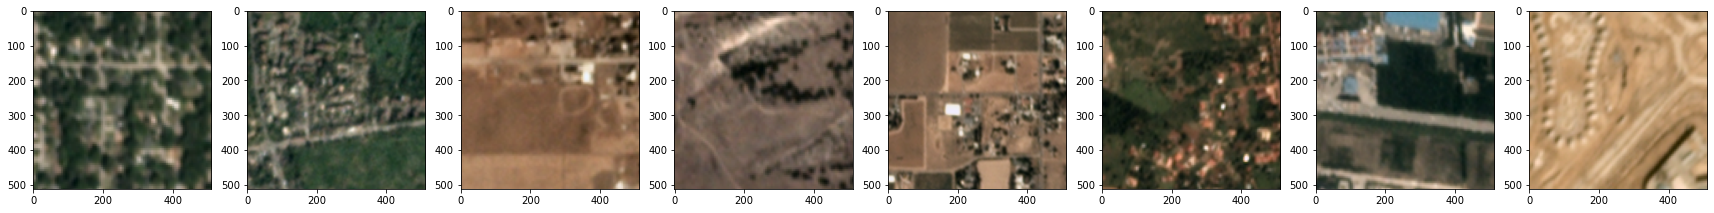

In [14]:
import matplotlib.pyplot as plt
import cv2
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    normalizedImg = np.zeros((512, 512))
    normalizedImg = cv2.normalize(np.array(images[x].permute(1, 2, 0)),  normalizedImg, 0, 1, cv2.NORM_MINMAX)
    axs[x].imshow(normalizedImg)
#     axs[x].imshow(images[x].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


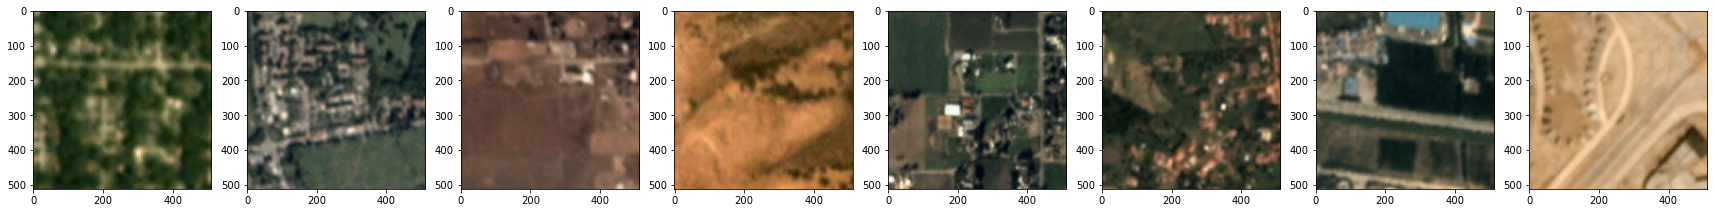

In [15]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    normalizedImg = np.zeros((512, 512))
    normalizedImg = cv2.normalize(np.array(images1[x].permute(1, 2, 0)),  normalizedImg, 0, 1, cv2.NORM_MINMAX)
    axs[x].imshow(normalizedImg)

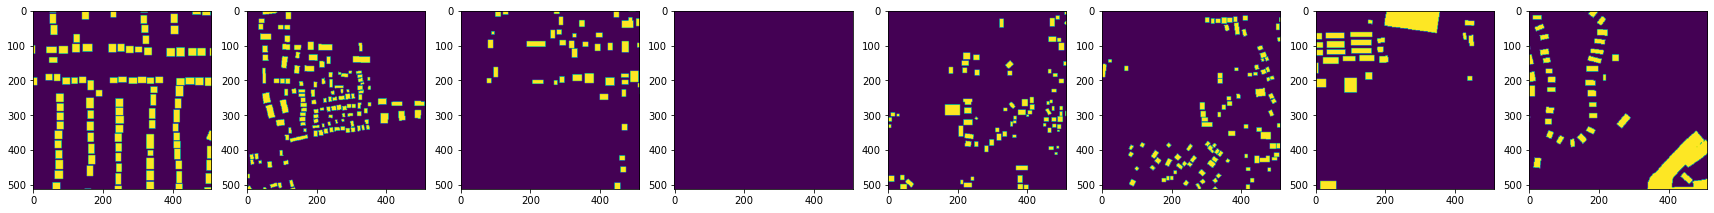

In [16]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(labels[x].permute(0, 1))

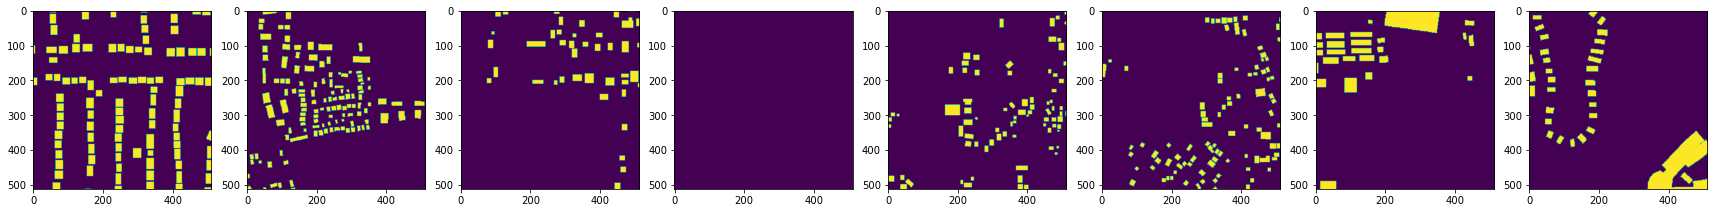

In [17]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(labels1[x].permute(0, 1))

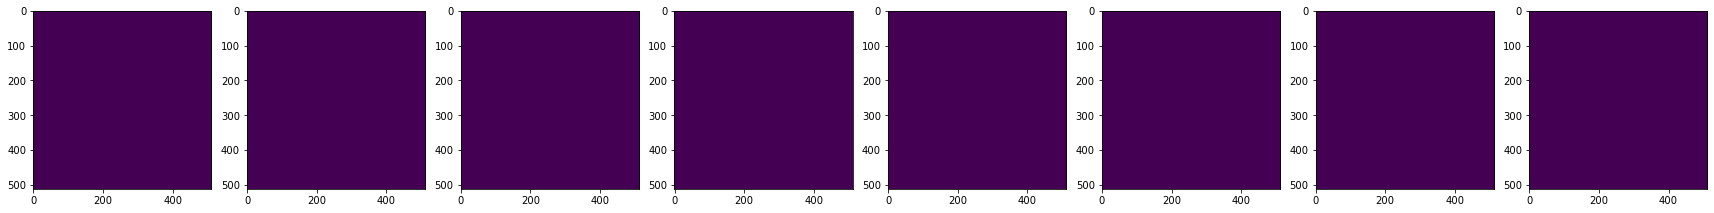

In [18]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(clouds[x].permute(0, 1))

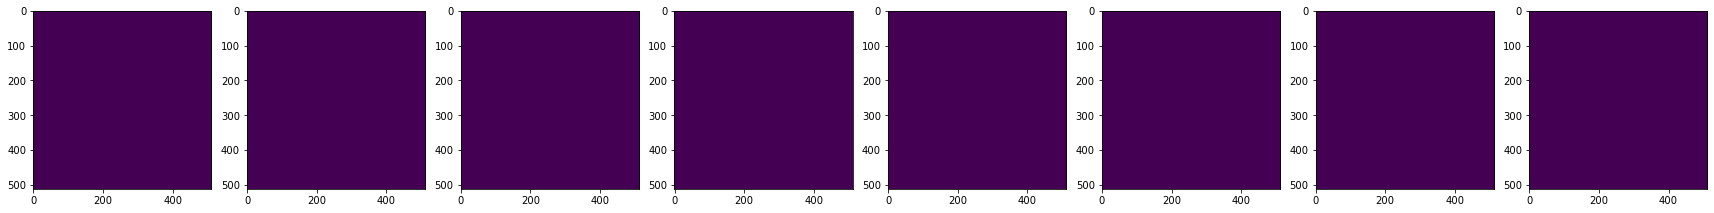

In [19]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(clouds1[x].permute(0, 1))

In [20]:
for i_iter, batch in enumerate(trainloader, 1):
    """
    TCR: two branches, CE1 + CE2 + TCR
    """
    images, labels, clouds, size, name, images1, labels1, clouds1, size1, name1 = batch
    break
    
print(name)
print(name1)

['global_monthly_2018_09_mosaic_L15-1204E-1202N_4816_3380_13_Buildings_01536_00000', 'global_monthly_2020_01_mosaic_L15-1335E-1166N_5342_3524_13_Buildings_01536_02048', 'global_monthly_2019_08_mosaic_L15-0977E-1187N_3911_3441_13_Buildings_02048_02048', 'global_monthly_2018_04_mosaic_L15-1538E-1163N_6154_3539_13_Buildings_01536_00000', 'global_monthly_2018_03_mosaic_L15-0760E-0887N_3041_4643_13_Buildings_01024_01024', 'global_monthly_2018_03_mosaic_L15-0361E-1300N_1446_2989_13_Buildings_01024_01536', 'global_monthly_2019_09_mosaic_L15-1289E-1169N_5156_3514_13_Buildings_00512_02048', 'global_monthly_2018_12_mosaic_L15-1709E-1112N_6838_3742_13_Buildings_02560_01024']
['global_monthly_2018_02_mosaic_L15-1204E-1202N_4816_3380_13_Buildings_01536_00000', 'global_monthly_2019_05_mosaic_L15-1335E-1166N_5342_3524_13_Buildings_01536_02048', 'global_monthly_2018_05_mosaic_L15-0977E-1187N_3911_3441_13_Buildings_02048_02048', 'global_monthly_2018_02_mosaic_L15-1538E-1163N_6154_3539_13_Buildings_0153

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


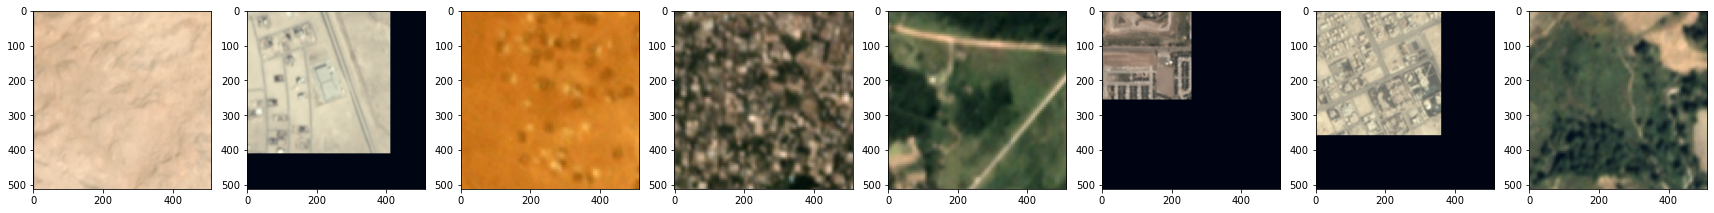

In [21]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    normalizedImg = np.zeros((512, 512))
    normalizedImg = cv2.normalize(np.array(images[x].permute(1, 2, 0)),  normalizedImg, 0, 1, cv2.NORM_MINMAX)
    axs[x].imshow(normalizedImg)
#     axs[x].imshow(images[x].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


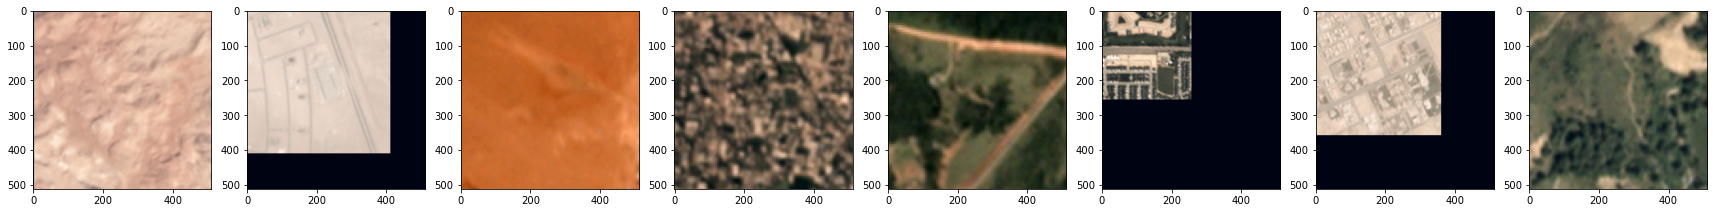

In [22]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    normalizedImg = np.zeros((512, 512))
    normalizedImg = cv2.normalize(np.array(images1[x].permute(1, 2, 0)),  normalizedImg, 0, 1, cv2.NORM_MINMAX)
    axs[x].imshow(normalizedImg)
#     axs[x].imshow(images1[x].permute(1, 2, 0))

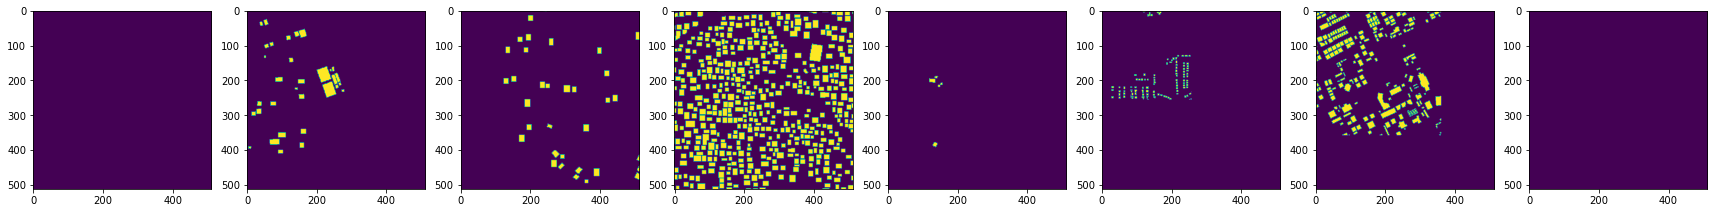

In [23]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(labels[x].permute(0, 1))

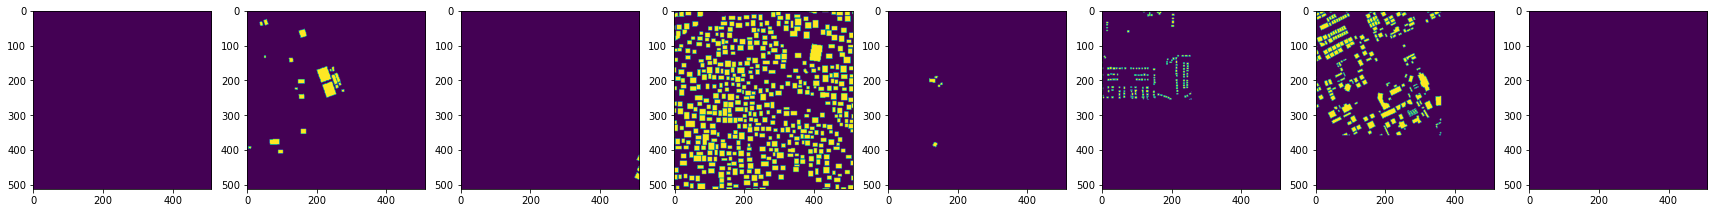

In [24]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(labels1[x].permute(0, 1))

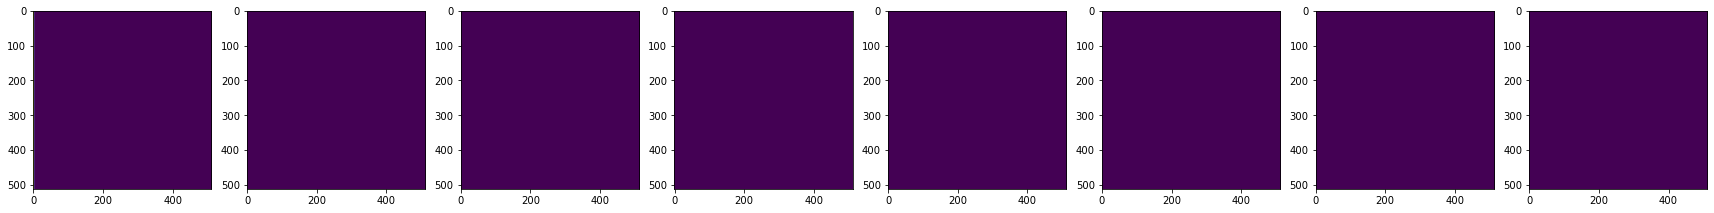

In [25]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(clouds[x].permute(0, 1))

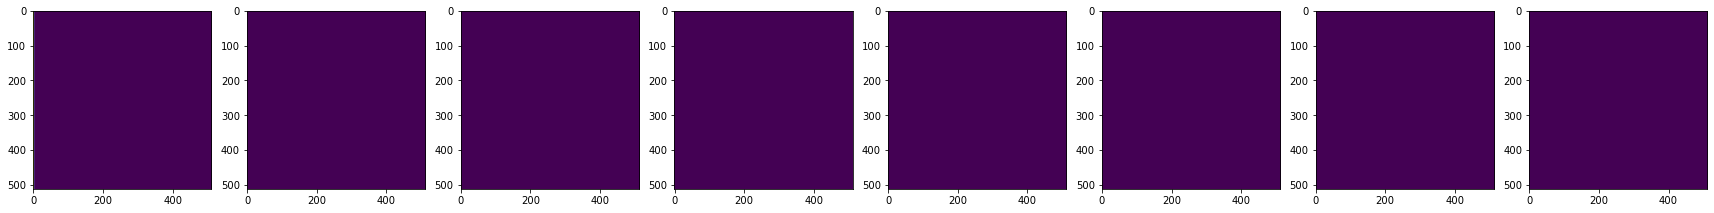

In [26]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(clouds1[x].permute(0, 1))

In [27]:
for i_iter, batch in enumerate(trainloader, 3):
    """
    TCR: two branches, CE1 + CE2 + TCR
    """
    images, labels, clouds, size, name, images1, labels1, clouds1, size1, name1 = batch
    break
    
print(name)
print(name1)

['global_monthly_2019_05_mosaic_L15-0487E-1246N_1950_3207_13_Buildings_00512_01536', 'global_monthly_2019_06_mosaic_L15-0760E-0887N_3041_4643_13_Buildings_01536_02048', 'global_monthly_2019_11_mosaic_L15-1296E-1198N_5184_3399_13_Buildings_01536_02560', 'global_monthly_2019_02_mosaic_L15-1703E-1219N_6813_3313_13_Buildings_01536_02048', 'global_monthly_2019_06_mosaic_L15-0434E-1218N_1736_3318_13_Buildings_01024_02048', 'global_monthly_2018_09_mosaic_L15-1669E-1160N_6678_3548_13_Buildings_01024_01536', 'global_monthly_2018_03_mosaic_L15-1210E-1025N_4840_4088_13_Buildings_02048_01536', 'global_monthly_2018_09_mosaic_L15-0368E-1245N_1474_3210_13_Buildings_00000_00512']
['global_monthly_2018_04_mosaic_L15-0487E-1246N_1950_3207_13_Buildings_00512_01536', 'global_monthly_2019_11_mosaic_L15-0760E-0887N_3041_4643_13_Buildings_01536_02048', 'global_monthly_2019_06_mosaic_L15-1296E-1198N_5184_3399_13_Buildings_01536_02560', 'global_monthly_2018_06_mosaic_L15-1703E-1219N_6813_3313_13_Buildings_0153

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


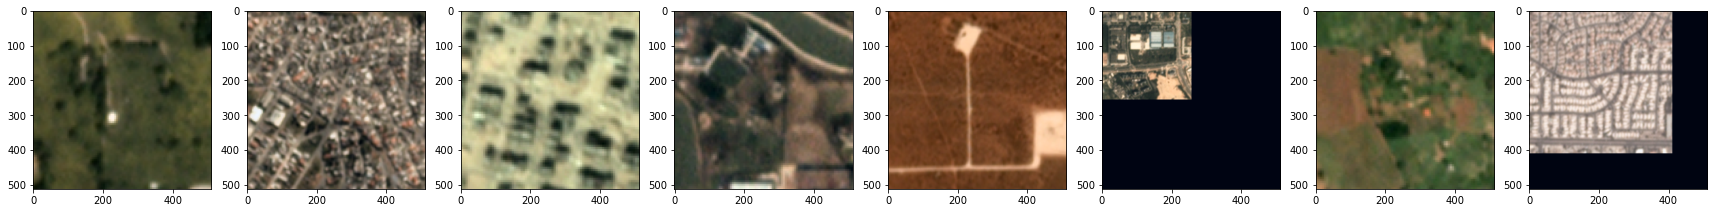

In [28]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    normalizedImg = np.zeros((512, 512))
    normalizedImg = cv2.normalize(np.array(images[x].permute(1, 2, 0)),  normalizedImg, 0, 1, cv2.NORM_MINMAX)
    axs[x].imshow(normalizedImg)
#     axs[x].imshow(images[x].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


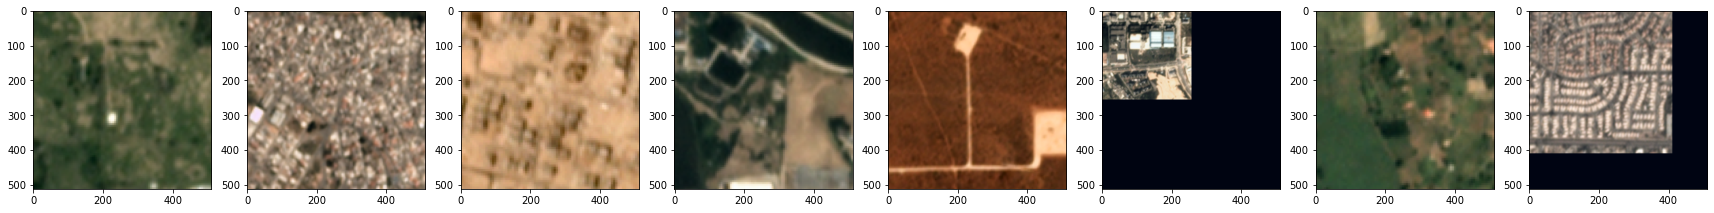

In [29]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
import cv2
for x in range(8):
    normalizedImg = np.zeros((512, 512))
    normalizedImg = cv2.normalize(np.array(images1[x].permute(1, 2, 0)),  normalizedImg, 0, 1, cv2.NORM_MINMAX)
    axs[x].imshow(normalizedImg)
#     axs[x].imshow(images1[x].permute(1, 2, 0))

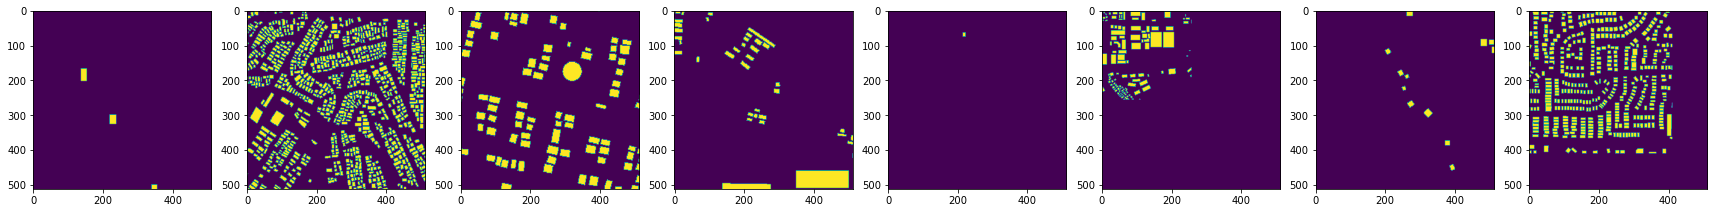

In [30]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(labels[x].permute(0, 1))

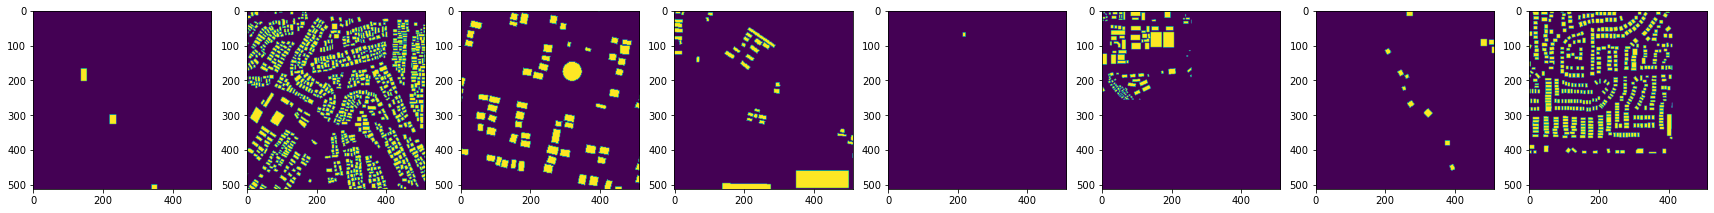

In [31]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(labels1[x].permute(0, 1))

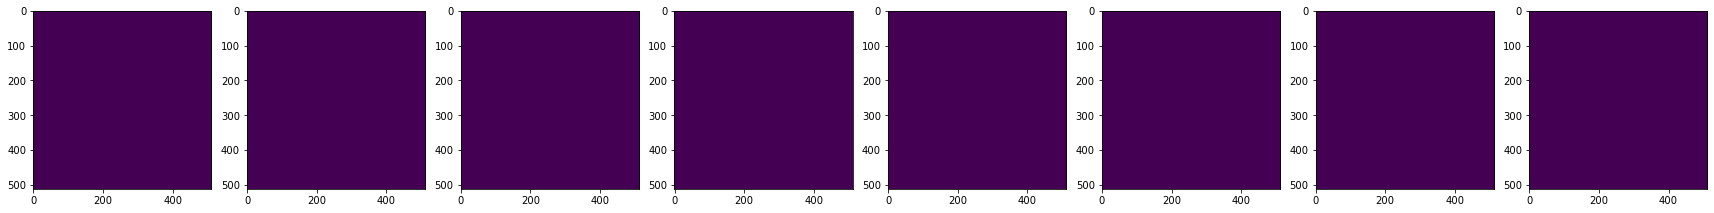

In [32]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(clouds[x].permute(0, 1))

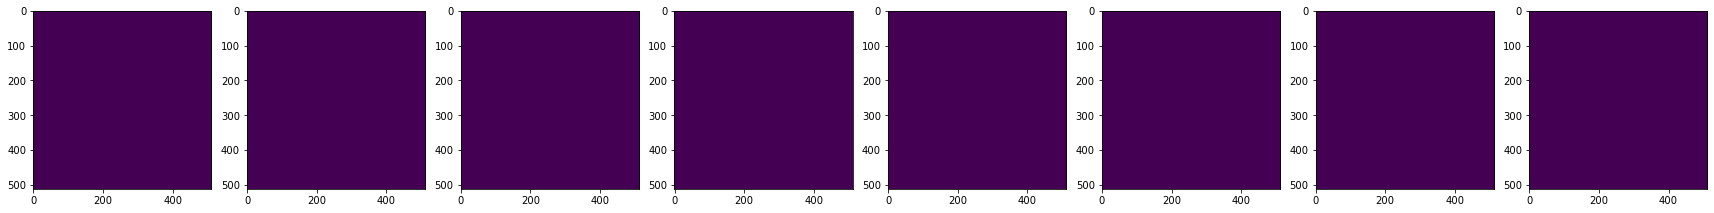

In [33]:
fig, axs = plt.subplots(1, 8, figsize=(30, 30))
for x in range(8):
    axs[x].imshow(clouds1[x].permute(0, 1))